In [1]:
import numpy as np 
# linear algebra
import pandas as pd 
# data processing, CSV file I/O (e.g. pd.read_csv)
import os
#写入当前目录的任何结果都将保存为输出。

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.backend import clear_session

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

d:\Anaconda3\envs\tf_2.4\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 读取数据
filname = './fer2013.csv'
#给数据分标签
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
#给数据加表头
names=['emotion','pixels','usage']
#读取文件
df=pd.read_csv('./fer2013.csv',names=names, na_filter=False)
#取像素列
im=df['pixels']
#展示数据
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [3]:
def getData(filname):
    # 读取出图片 48*48
    # N = 35887
    Y = []
    X = []
    first = True
    #循环读取filename中的图片像素数据
    for line in open(filname):
        if first:
            first = False
        else:
            #以，为间隔将第一列的情绪赋值给Y，将后面的像素赋值给X
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])
    #将X的取值放在0-1之间进行array转换
    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y


In [4]:
X, Y = getData(filname)
#得到数据有几组分类
num_class = len(set(Y))
print(num_class)

7


In [5]:
X.shape

(35887, 2304)

In [6]:
#一共有35887组图片像素赋值给N，每一个图片有2304个像素赋值给D
N, D = X.shape
X = X.reshape(N, 48, 48, 1)
X.shape

(35887, 48, 48, 1)

In [7]:
# 切分数据集
#训练集与测试机9：1
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
#将数据映射到01
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [8]:
INIT_LR = 0.01
EPOCHS = 50
BS = 64

# VGG

In [9]:
#定义卷积神经网络VGG
def get_vgg(classes=7):
    #在进行keras的交叉验证时，清空session否则上一折的训练集成了这一折的验证集，数据泄露
    clear_session()
    #序列模型，逐层添加网络
    model=Sequential()
    #输入维度
    input_shape = (48,48,1)

    model.add(Conv2D(64, (3, 3), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    #BatchNormalization批标准化减少梯度消失，加快了收敛过程。起到类似dropout一样的正则化能力，一定程度上防止过拟合。
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    #对多维数据的降维函数，将数据转为一维
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(classes))
    #softmax一般用于多分类的结果，一般和one-hot的真实标签值配合使用，大多数用于网络的最后一层；
    model.add(Activation('softmax'))
######
    opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    #多分类的对数损失函数，与softmax分类器相对应的损失函数，optimizer优化器，metrics指标
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)
    
#打印出网络的结构和参数统计
    model.summary()
    return model
model = get_vgg()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1

C:\Users\sha\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


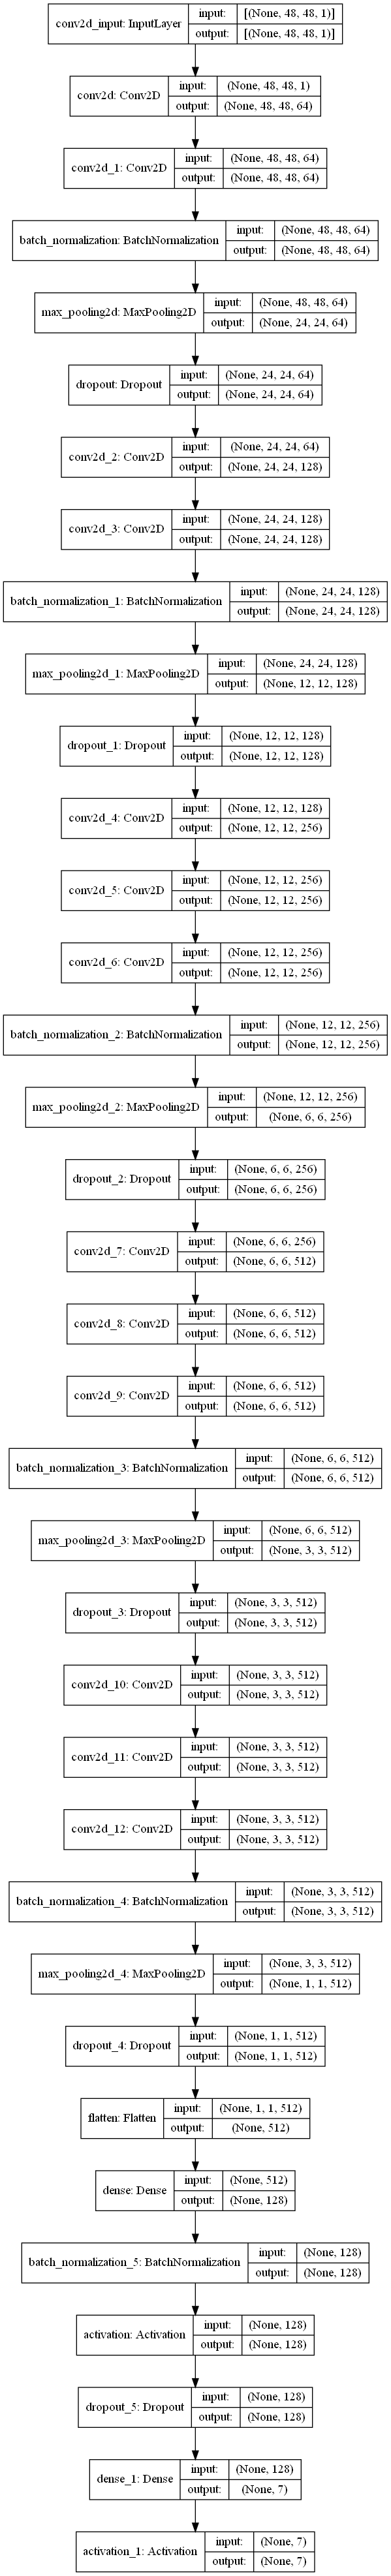

In [10]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='fer_VGG.png', show_shapes=True,show_layer_names=True)
Image(filename='fer_VGG.png') 

In [15]:
VGG_HISTORY=model.fit(
            #训练数据的 Numpy 数组
            x=X_train,     
            #目标（标签）数据的 Numpy 数组
            y=y_train, 
            #每次梯度更新的样本数
            batch_size=BS, 
            #迭代次数
            epochs=EPOCHS, 
            #0, 1 或 2。日志显示模式。 0 = 安静模式, 1 = 进度条, 2 = 每轮一行。
            verbose=1, 
            #评估损失
            validation_data=(X_test,y_test),
            #对一个 batch 内部的数据进行混洗
            shuffle=True,
            )

Epoch 1/50
505/505 [==============================] - 20s 39ms/step - loss: 1.9403 - accuracy: 0.2279 - val_loss: 1.8090 - val_accuracy: 0.2575
Epoch 2/50
505/505 [==============================] - 19s 38ms/step - loss: 1.8279 - accuracy: 0.2628 - val_loss: 1.7421 - val_accuracy: 0.2945
Epoch 3/50
505/505 [==============================] - 19s 38ms/step - loss: 1.7493 - accuracy: 0.3063 - val_loss: 1.6562 - val_accuracy: 0.3491
Epoch 4/50
505/505 [==============================] - 20s 39ms/step - loss: 1.6867 - accuracy: 0.3351 - val_loss: 1.5828 - val_accuracy: 0.3781
Epoch 5/50
505/505 [==============================] - 19s 37ms/step - loss: 1.6278 - accuracy: 0.3600 - val_loss: 1.5700 - val_accuracy: 0.3920
Epoch 6/50
505/505 [==============================] - 18s 35ms/step - loss: 1.5716 - accuracy: 0.3868 - val_loss: 1.5670 - val_accuracy: 0.3998
Epoch 7/50
505/505 [==============================] - 18s 35ms/step - loss: 1.5282 - accuracy: 0.4034 - val_loss: 1.4694 - val_accuracy:

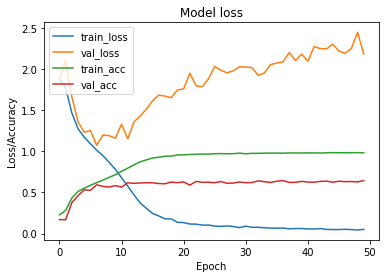

In [11]:
# 绘制训练 & 验证的损失值
#优化函数为adam
'''
train loss 不断下降，val_loss不断下降，说明网络仍在学习;（最好的）
train loss 不断下降，val_loss趋于不变，说明网络过拟合;（max pool或者正则化）
train loss 趋于不变，val_loss不断下降，说明数据集100%有问题;（检查dataset）
train loss 趋于不变，val_loss趋于不变，说明学习遇到瓶颈，需要减小学习率或批量数目;（减少学习率）
train loss 不断上升，val_loss不断上升，说明网络结构设计不当，训练超参数设置不当，数据集经过清洗等问题。（最不好的情况）
'''
N = np.arange(0, 50)
plt.plot(N,VGG_HISTORY.history['loss'],label="train_loss")
plt.plot(N,VGG_HISTORY.history['val_loss'],label="val_loss")
plt.plot(N,VGG_HISTORY.history['accuracy'],label="train_acc")
plt.plot(N,VGG_HISTORY.history['val_accuracy'],label="val_acc")
plt.title('Model loss')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=objects))

              precision    recall  f1-score   support

       angry       0.54      0.58      0.56       484
     disgust       0.74      0.52      0.61        56
        fear       0.57      0.43      0.49       502
       happy       0.75      0.87      0.81       920
         sad       0.54      0.55      0.54       599
    surprise       0.82      0.74      0.78       442
     neutral       0.57      0.57      0.57       586

    accuracy                           0.64      3589
   macro avg       0.65      0.61      0.62      3589
weighted avg       0.64      0.64      0.64      3589



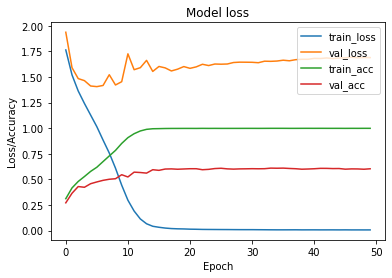

In [10]:
# 绘制训练 & 验证的损失值
#优化函数为sgd learning rate为0.01
'''
train loss 不断下降，val_loss不断下降，说明网络仍在学习;（最好的）
train loss 不断下降，val_loss趋于不变，说明网络过拟合;（max pool或者正则化）
train loss 趋于不变，val_loss不断下降，说明数据集100%有问题;（检查dataset）
train loss 趋于不变，val_loss趋于不变，说明学习遇到瓶颈，需要减小学习率或批量数目;（减少学习率）
train loss 不断上升，val_loss不断上升，说明网络结构设计不当，训练超参数设置不当，数据集经过清洗等问题。（最不好的情况）
'''
N = np.arange(0, 50)
plt.plot(N,VGG_HISTORY.history['loss'],label="train_loss")
plt.plot(N,VGG_HISTORY.history['val_loss'],label="val_loss")
plt.plot(N,VGG_HISTORY.history['accuracy'],label="train_acc")
plt.plot(N,VGG_HISTORY.history['val_accuracy'],label="val_acc")
plt.title('Model loss')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=objects))

              precision    recall  f1-score   support

       angry       0.52      0.47      0.49       484
     disgust       0.71      0.57      0.63        56
        fear       0.48      0.43      0.45       502
       happy       0.77      0.81      0.79       920
         sad       0.46      0.48      0.47       599
    surprise       0.77      0.73      0.75       442
     neutral       0.52      0.57      0.54       586

    accuracy                           0.60      3589
   macro avg       0.60      0.58      0.59      3589
weighted avg       0.60      0.60      0.60      3589



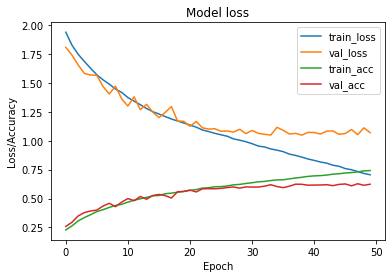

In [16]:
# 绘制训练 & 验证的损失值
#优化函数为sgd learning rate为0.01，加入drop out为0.25
N = np.arange(0, 50)
plt.plot(N,VGG_HISTORY.history['loss'],label="train_loss")
plt.plot(N,VGG_HISTORY.history['val_loss'],label="val_loss")
plt.plot(N,VGG_HISTORY.history['accuracy'],label="train_acc")
plt.plot(N,VGG_HISTORY.history['val_accuracy'],label="val_acc")
plt.title('Model loss')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=objects))

              precision    recall  f1-score   support

       angry       0.56      0.51      0.53       484
     disgust       0.70      0.50      0.58        56
        fear       0.44      0.50      0.47       502
       happy       0.85      0.81      0.83       920
         sad       0.50      0.45      0.47       599
    surprise       0.73      0.80      0.76       442
     neutral       0.54      0.59      0.57       586

    accuracy                           0.62      3589
   macro avg       0.62      0.59      0.60      3589
weighted avg       0.63      0.62      0.62      3589



# 胶囊神经网络实现

胶囊网络有两个主要特性：第一是基于层的压缩，第二是动态路由。典型的神经网络只有一个单元输出被非线性挤压，所以我们有一套输出神经元，而且基于每个输出神经元，我们给每个神经元应用非线性而不是给每个个体神经元应用非线性，组合这些神经元到一个胶囊中，然后应用非线性到整个神经元集。所以当我们应用非线性的时候，对整个层而不是对个体神经元实现动态路由，它用矢量输出胶囊取代了输出映射检测器，而且它通过路由和协议取代了最大化池化。

每个层中的每个胶囊当它们向前传播数据的时候，会进入下一个最相关的胶囊中，有点像层内嵌套层的层次结构树，这一新架构的代价是这个路由算法。

In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

In [12]:
"""
压缩函数,使用0.5替代1,如果是1，所有的向量的范数都将被缩小。
如果是0.5，小于0.5的范数将缩小，大于0.5的将被放大
"""
def squash(x, axis=-1):
     # 即S向量模长的平方
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm)/ (0.5 + s_squared_norm)
    return scale * x

"""
定义我们自己的softmax函数，而不是K.softmax.因为K.softmax不能指定轴
因为在后面的步骤中，轴发生了交换，因此需要特别指定softmax轴，其余的与softmax一样
"""
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex/K.sum(ex, axis=axis, keepdims=True)

In [13]:
#A Capsule Implement with Pure Keras

class Capsule(Layer):
    """编写自己的Keras层需要重写3个方法以及初始化方法
    1.build(input_shape):这是你定义权重的地方。
    这个方法必须设self.built = True，可以通过调用super([Layer], self).build()完成。
    2.call(x):这里是编写层的功能逻辑的地方。
    你只需要关注传入call的第一个参数：输入张量，除非你希望你的层支持masking。
    3.compute_output_shape(input_shape):
     如果你的层更改了输入张量的形状，你应该在这里定义形状变化的逻辑，这让Keras能够自动推断各层的形状。
    4.初始化方法,你的神经层需要接受的参数
    """ 
    #num_capsule胶囊数量  dim_capsule胶囊尺寸  routings动态路由迭代次数  
    def __init__(self, num_capsule, dim_capsule, routings=3, share_weights=True, activation='squash', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation) #得到激活函数
    #定义权重
    def build(self, input_shape):
         # 必须继承Layer的build方法
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            #自定义权重
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            #自定义权重
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
 # 层的功能逻辑(核心)
    def call(self, u_vecs):
        if self.share_weights:
             # 用一维卷积替代类似的全连接层
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            #未共享权重的conv1d
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])
    
        #批次数目
        batch_size = K.shape(u_vecs)[0]
        #输入胶囊的个数
        input_num_capsule = K.shape(u_vecs)[1]
        
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule,
                                            self.num_capsule, self.dim_capsule))
        # 交换轴
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        #final u_hat_vecs.shape = [None, num_capsule, input_num_capsule, dim_capsule]
	    # 动态路由算法更新b
         # 步骤1，初始化为0
        b = K.zeros_like(u_hat_vecs[:,:,:,0]) 
        # 迭代步骤2-5 r次 
        for i in range(self.routings):
            c = softmax(b, 1)# 步骤2，softmax
            o = tf.einsum('bin,binj->bij', c, u_hat_vecs)# 步骤3，批量矩阵相乘
            if K.backend() == 'theano': # 步骤4
                o = K.sum(o, axis=1)
            if i < self.routings-1:
                o = K.l2_normalize(o, -1)
                # b = K.batch_dot(o, u_hat_vecs, [2, 3])
                b = tf.einsum('bij,binj->bin', o, u_hat_vecs)
                if K.backend() == 'theano':
                    b = K.sum(b, axis=1)

            # c = softmax(b, 1)# 步骤2，softmax
            # s = K.batch_dot(c, u_hat_vecs, [2, 2])  # 步骤3，批量矩阵相乘
            # o = self.activation(s)  # 步骤4
            # if i < self.routings - 1:
            #     b += K.batch_dot(o, u_hat_vecs, [2, 3])  # 步骤5
               
        return self.activation(o)
     # 自动推断shape
    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)


In [53]:
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import TruncatedNormal

In [14]:
def get_Capsule(classes=7):
    clear_session()

    input_image = Input(shape=(48,48,1))
    x = Conv2D(64, (3, 3), input_shape=(48,48,1),activation='relu', padding='same')(input_image)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (3, 3),activation='relu',padding='same')(x)
    x = Conv2D(128, (3, 3),activation='relu',padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(256, (3, 3),activation='relu',padding='same')(x)
    x = Conv2D(256, (3, 3),activation='relu',padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(512, (3, 3),activation='relu',padding='same')(x)
    x = Conv2D(512, (3, 3),activation='relu',padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(512, (3, 3),activation='relu',padding='same')(x)
    x = Conv2D(512, (3, 3),activation='relu',padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    cnn = Reshape((-1, 128))(x)
    capsule = Capsule(10, 25, 3, False)(cnn)

    x = Flatten()(capsule)
    
    output =  Dense(classes,activation='softmax')(x)

    model = Model(inputs=input_image, outputs=output)
	
    #optim = optim.SGD(parameters(), lr=INIT_LR, weight_decay=1e-2)
    opt = SGD(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

    model.summary()
    return model
model = get_Capsule()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856 

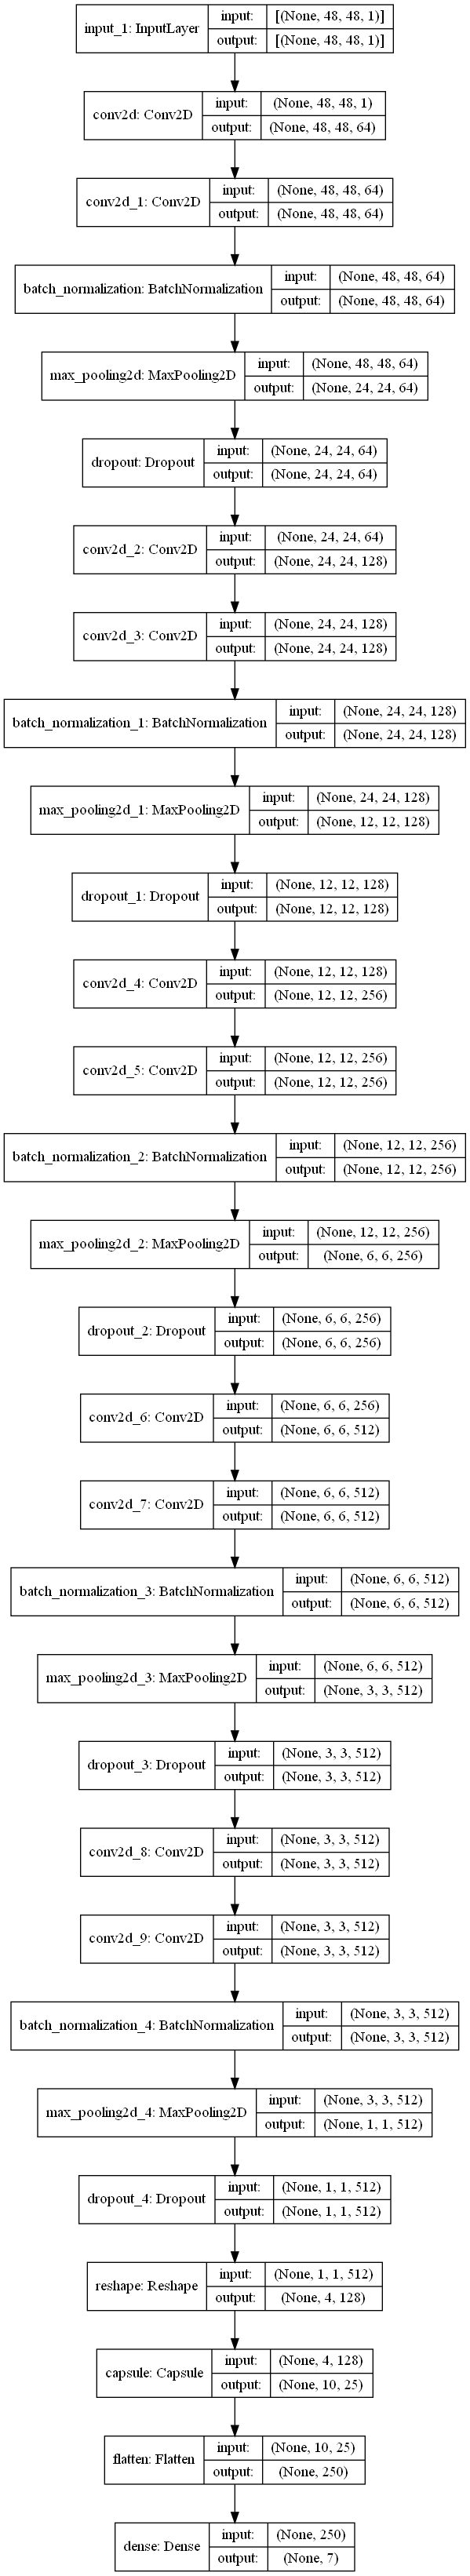

In [15]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='fer_capsule.png', show_shapes=True,show_layer_names=True)
Image(filename='fer_capsule.png') 

In [19]:
capsule_history=model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=30, 
            verbose=1, 
            validation_data=(X_test,y_test),
            shuffle=True)

Epoch 1/30
505/505 [==============================] - 24s 33ms/step - loss: 1.7917 - accuracy: 0.2552 - val_loss: 1.8365 - val_accuracy: 0.2569
Epoch 2/30
505/505 [==============================] - 16s 32ms/step - loss: 1.7353 - accuracy: 0.2924 - val_loss: 1.7107 - val_accuracy: 0.3218
Epoch 3/30
505/505 [==============================] - 16s 31ms/step - loss: 1.6619 - accuracy: 0.3462 - val_loss: 1.6540 - val_accuracy: 0.3594
Epoch 4/30
505/505 [==============================] - 16s 31ms/step - loss: 1.5849 - accuracy: 0.3793 - val_loss: 1.6426 - val_accuracy: 0.3778
Epoch 5/30
505/505 [==============================] - 28s 55ms/step - loss: 1.5187 - accuracy: 0.4110 - val_loss: 1.6739 - val_accuracy: 0.3856
Epoch 6/30
505/505 [==============================] - 27s 54ms/step - loss: 1.4644 - accuracy: 0.4357 - val_loss: 1.5083 - val_accuracy: 0.4168
Epoch 7/30
505/505 [==============================] - 23s 46ms/step - loss: 1.4150 - accuracy: 0.4561 - val_loss: 1.3742 - val_accuracy:

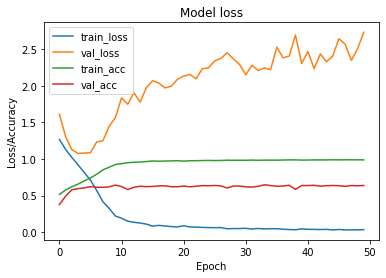

In [34]:
# 绘制训练 & 验证的损失值
#优化函数为adam
N = np.arange(0, 50)
plt.plot(N,capsule_history.history['loss'],label="train_loss")
plt.plot(N,capsule_history.history['val_loss'],label="val_loss")
plt.plot(N,capsule_history.history['accuracy'],label="train_acc")
plt.plot(N,capsule_history.history['val_accuracy'],label="val_acc")
plt.title('Model loss')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

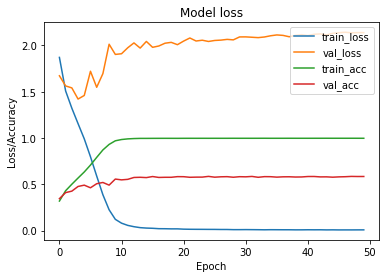

In [37]:
# 绘制训练 & 验证的损失值
#优化函数为sgd  学习率为0.01
N = np.arange(0, 50)
plt.plot(N,capsule_history.history['loss'],label="train_loss")
plt.plot(N,capsule_history.history['val_loss'],label="val_loss")
plt.plot(N,capsule_history.history['accuracy'],label="train_acc")
plt.plot(N,capsule_history.history['val_accuracy'],label="val_acc")
plt.title('Model loss')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

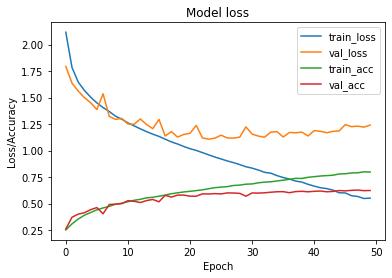

In [42]:
# 绘制训练 & 验证的损失值
#优化函数为sgd  学习率为0.01 加入dropout
N = np.arange(0, 50)
plt.plot(N,capsule_history.history['loss'],label="train_loss")
plt.plot(N,capsule_history.history['val_loss'],label="val_loss")
plt.plot(N,capsule_history.history['accuracy'],label="train_acc")
plt.plot(N,capsule_history.history['val_accuracy'],label="val_acc")
plt.title('Model loss')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

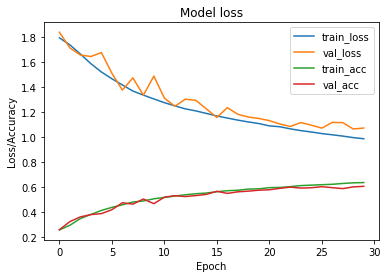

In [20]:
# 绘制训练 & 验证的损失值
#优化函数为sgd  学习率为0.01 加入dropout 减少epoch降低过拟合
N = np.arange(0, 30)
plt.plot(N,capsule_history.history['loss'],label="train_loss")
plt.plot(N,capsule_history.history['val_loss'],label="val_loss")
plt.plot(N,capsule_history.history['accuracy'],label="train_acc")
plt.plot(N,capsule_history.history['val_accuracy'],label="val_acc")
plt.title('Model loss')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# ResNet

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
#import skimage.io
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [9]:
#数据增强
train_datagen = ImageDataGenerator(
        #所有数据集将乘以该数值
        rescale = 1./255,
        #选取训练集中的一部分作为验证集
        validation_split = 0.2,
        #随即旋转角度数范围                          
        rotation_range=5,
        #随即宽度偏移量
        width_shift_range=0.2,
        #随即高度偏移量
        height_shift_range=0.2,
        #剪切范围
        shear_range=0.2,
        #随机水平翻转
        horizontal_flip=True,
        #垂直翻转
        vertical_flip=True,
        fill_mode='nearest'
        )

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                 #选取训练集中的一部分作为验证集
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [10]:
train_dataset  = train_datagen.flow_from_directory(directory = './fer2013/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [11]:
valid_dataset = valid_datagen.flow_from_directory(directory = './fer2013/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [12]:
test_dataset = test_datagen.flow_from_directory(directory = './fer2013/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


(48, 48, 3)
(1, 48, 48, 3)


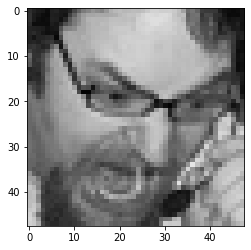

In [13]:
from tensorflow.keras.preprocessing import image
img = image.load_img("./fer2013/test/angry/PrivateTest_10131363.jpg",target_size=(48,48))
img = np.array(img)
plt.imshow(img)
print(img.shape)
#拓展维度
img = np.expand_dims(img, axis=0)
from tensorflow.keras.models import load_model
print(img.shape)

In [14]:
#weights：None代表随机初始化，即不加载预训练权重；'imagenet’代表加载预训练权重。 include_top：是否保留顶层的全连接网络
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [29]:
# 冻结层
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [30]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 8192)              32768     
_________________________________________________________________
dense_8 (Dense)              (None, 32)                262176    
_________________________________________________________________
batch_normalization_9 (Batch (None, 32)                128       
_________________________________________________________________
activation_6 (Activation)    (None, 32)               

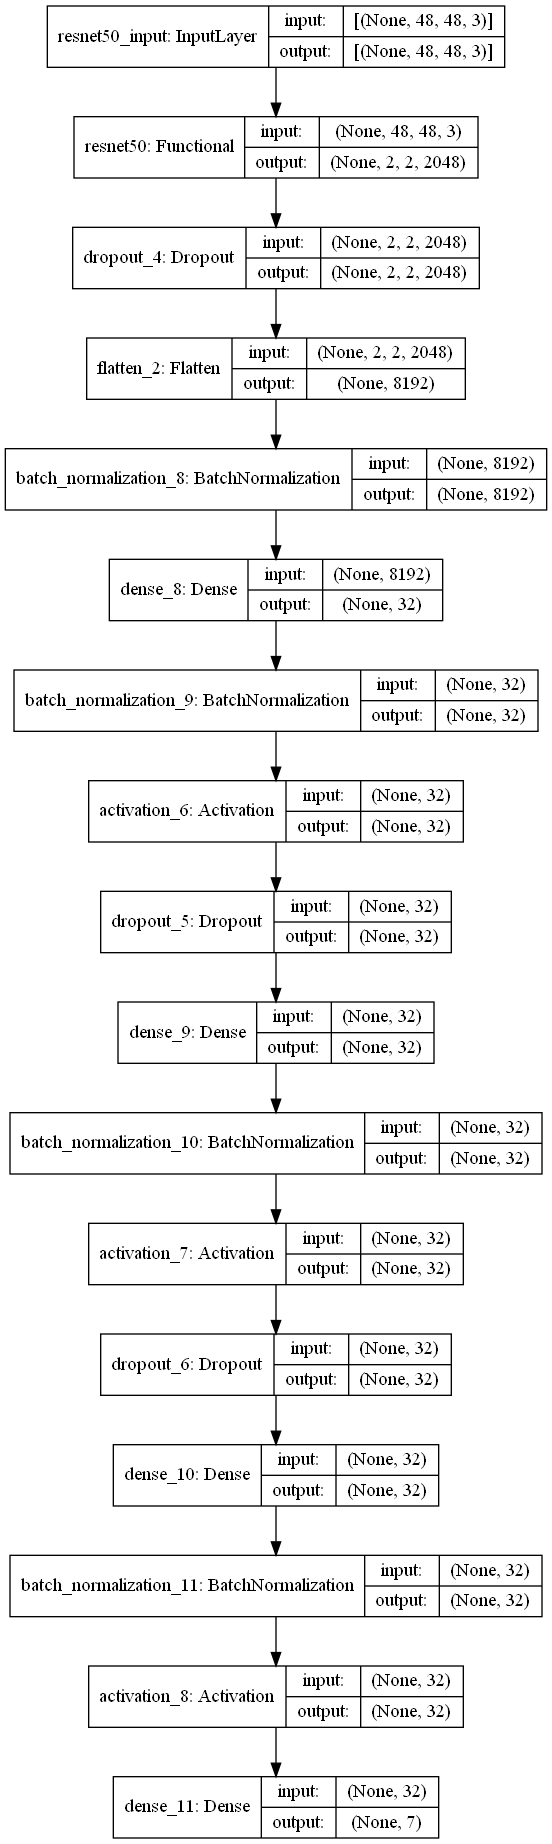

In [31]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [32]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
       # f1_score,
]

In [33]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [34]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [35]:
history=model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs = 50,
    verbose = 1,
    callbacks=[lrd,mcp,es])

Epoch 1/50
359/359 [==============================] - 19s 48ms/step - loss: 1.5202 - accuracy: 0.8748 - precision: 0.7925 - recall: 0.1674 - auc: 0.7902 - val_loss: 1.2531 - val_accuracy: 0.8902 - val_precision: 0.7978 - val_recall: 0.3099 - val_auc: 0.8677
Epoch 2/50
359/359 [==============================] - 17s 46ms/step - loss: 1.3344 - accuracy: 0.8845 - precision: 0.7991 - recall: 0.2559 - auc: 0.8456 - val_loss: 1.2317 - val_accuracy: 0.8902 - val_precision: 0.8108 - val_recall: 0.3015 - val_auc: 0.8705
Epoch 3/50
359/359 [==============================] - 16s 44ms/step - loss: 1.3112 - accuracy: 0.8859 - precision: 0.7914 - recall: 0.2734 - auc: 0.8514 - val_loss: 1.2207 - val_accuracy: 0.8909 - val_precision: 0.7996 - val_recall: 0.3155 - val_auc: 0.8724
Epoch 4/50
359/359 [==============================] - 16s 43ms/step - loss: 1.2975 - accuracy: 0.8855 - precision: 0.7736 - recall: 0.2806 - auc: 0.8545 - val_loss: 1.2174 - val_accuracy: 0.8913 - val_precision: 0.8043 - val_r

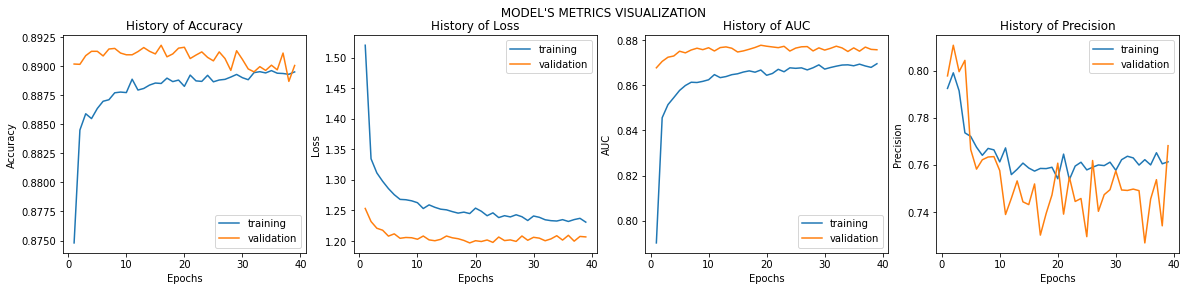

In [36]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)
#未使用冻结层
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,4))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    # ax5.plot(range(1, len(f1) + 1), f1)
    # ax5.plot(range(1, len(val_f1) + 1), val_f1)
    # ax5.set_title('History of F1-score')
    # ax5.set_xlabel('Epochs')
    # ax5.set_ylabel('F1 score')
    # ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
            #    history.history['f1_score'],history.history['val_f1_score']
              )